# Hands-on ML with Python 
# Chapter 02: End-to-End ML Project

Using `sklearn` to predict the median price of houses in California using the California `StatLib` dataset. 

## Setup

In [91]:
# For access to linker/compiler functionality
import sys
assert sys.version_info >= (3, 5)

# Sklearn for creating ML models
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os 

# For plotting pretty figures with matplotlib
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Save figures in a separate subdirectory
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save matplotlib images as PNGs 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

## Get the Data
Will write a small function that makes a request to a URL and downloads the latest version of the dataset as a `tgz` file with the dataset's CSV. While this can be done manually, writing a small function to do this can be useful if
- the data changes frequently and has to be fetched on a recurring basis.
- the data has to be downloaded on multiple machines.

In [92]:
import os 
import tarfile
from six.moves import urllib

In [93]:
# Defining filepaths and URLs as constants that will be used to fetch data
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz' 

In [94]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # If the datasets dir does not exist yet, make the dir
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    # The TGZ file will be downloaded to the housing dataset folder as `housing.tgz`
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    
    # Make a request to the URL to download the file to the right location
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # Open, extract, and close the tgz file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

## Load the Data with `pandas`

In [95]:
import pandas as pd

In [96]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [97]:
housing = load_housing_data()

## Initial Data Analysis

In [98]:
# Examine the first few rows in the dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
# A summary of the number of attributes in each column - to help identify missing values
# Along with their data types and names
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- `total_bedrooms` has only 20,433 values while all others have 20,640 values. This mean there $20,640 - 20,433 = 207$ missing values in this column, which we will have to deal with later.
- `ocean_proximity` is of type `object`, which means it is most likely text (since the data was loaded from a CSV). ML models can only work with numeric data, so `ocean_proximity` will have to be converted to a numeric variable (categorical numeric variable). 

In [10]:
# How many houses are NEAR BAY, INLAND, NEAR OCEAN, or on an ISLAND?
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
# describe shows statistical summary of each numerical attribute
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


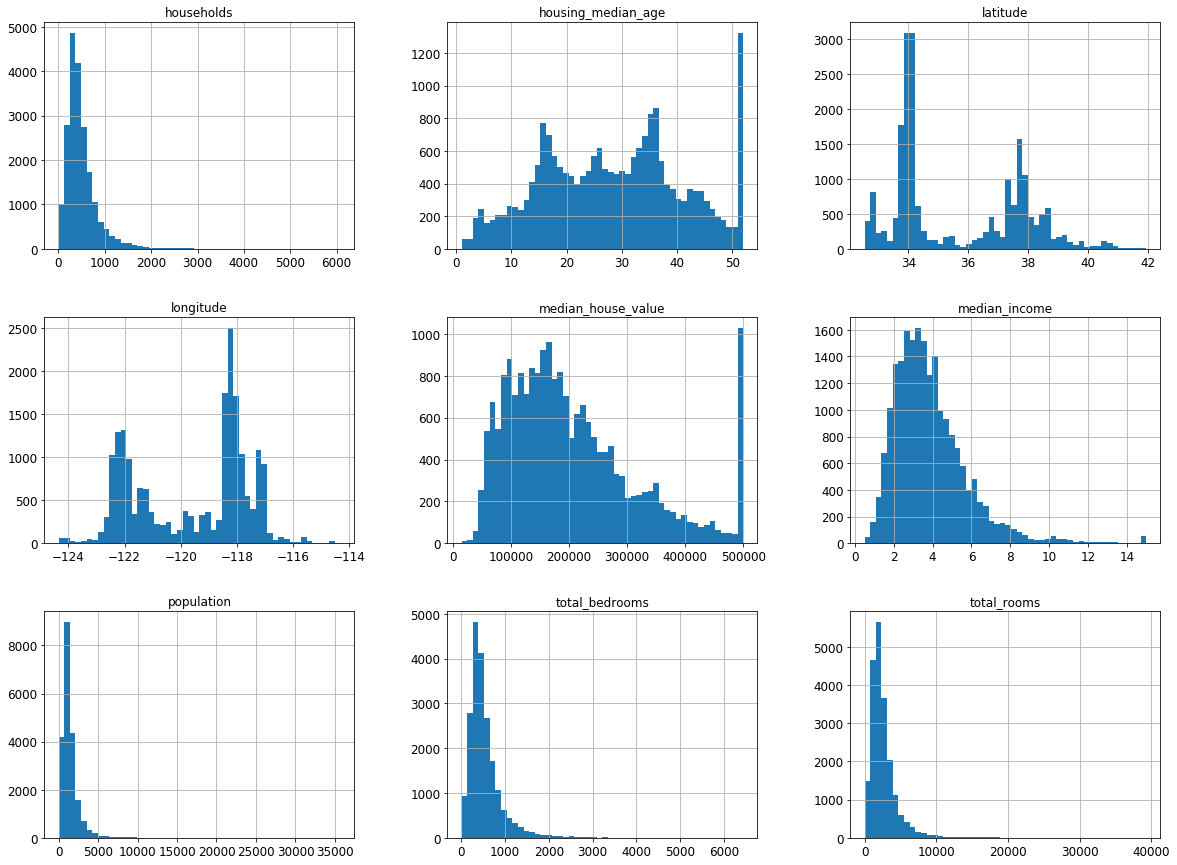

Saving figure  feature_histograms


<Figure size 432x288 with 0 Axes>

In [12]:
# Configuring matplotlib to use Jupyter's backend for generating plots and to display all plots in notebook
%matplotlib inline

# Plotting histograms for all numeric data to visualize trends/distribution
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()
save_fig('feature_histograms')

- A lot of these features are tail heavy or have fat tailed distributions. This means they extend much farther to the right than to the left of the median. This can be a problem for some ML algos, and we will have to standardise these features.
- `median_house_value` was capped at 500k, which is why the histogram for this feature shows a spike at 500k. This is a problem, because this is actually the target that we will try to predict.
    - If we want to include these samples in the training data, we will have to find the right labels for these samples.
    - If we can't get correct labels, we should remove them from the training set and test set.
- All features have very different ranges of values, and must be scaled to occupy the same range of values e.g. 0 - 1, or -1 to 1.
- `median_income` was not measured in dollars (see the x-axis). It was scaled and mapped to a range of 15 for max and 0.5 for min incomes. This may not be a problem, but it helps to understand how the data has been preprocessed.

## Create Test Set

In [99]:
import numpy as np

# seed the random number generator to match the book's results
# Also to ensure that the same random list of train/test indices are achieved every time 
# the program is run
np.random.seed(42)

In [100]:
# Defining our own function to split the data into train/test sets
# This is very similar to what `sklearn` does
def split_train_test(data, test_ratio):
    # Use the length of the data to return a randomly permuted range of indices
    shuffled_indices = np.random.permutation(len(data))
    
    # Number of samples in the test set must be a whole number or integer
    test_set_size = int(len(data) * test_ratio)
    
    # The first `test_set_size` indices in the randomly shuffled list of indices are for the test set
    test_indices = shuffled_indices[:test_set_size]
    
    # The remaining indices are for the training set
    train_indices = shuffled_indices[test_set_size:]
    
    # Find the rows at the specified indices for training and test data and return them
    # iloc means using a row's indexed-based location in the dataset
    return data.iloc[train_indices], data.iloc[test_indices]

In [101]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Train set size:\t{len(train_set)}")
print(f"Test set size:\t{len(test_set)}")

Train set size:	16512
Test set size:	4128


## What's wrong with this approach?
- If we use a random number generator to fetch training/test data each time the program/notebook is run, it will fetch different data. 
    - This is bad because then our results will not be reproducible. 
    - Also, over time this will mean that the ML model will get to see the whole dataset.
- We could seed the random number generator or save the test set on the first run, and then load the test set on subsequent runs.
    - This avoids the problem of different train/test data being loaded each time. 
- However, this approach will break the moment the dataset is updated or we fetch new data. 

**Solution**: Use each sample's unique identifier to hash it. If the hash is lower than or equal to 20% of the maximum hash value, put it in the test set. Ensures test set will remain consistent across multiple runs, even if the dataset is refreshed. New test set will contain 20% of new instances, but not any instance that was previously in the training set.

## Hashing for Test Set
Had to use the third hash function - the one that works for both Python 2 and Python 3. The first hash function was causing issues because it was returning indices that weren't present in the `index` column in the dataset. Probably an error on my part, but I was not able to debug it.

In [102]:
import hashlib

In [103]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [104]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [105]:
housing_with_id = housing.reset_index() # Add an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [106]:
print(f"Training samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Training samples: 16362
Test samples: 4278


If we're using the `index` or the row number of a sample for hashing, we have to make sure that any new data is always added to the end of the dataset, and that no existing row is ever deleted.

For obvious reasons, this is difficult to do in practice. The solution is to use a feature that will be both unique and relatively stable across all examples in the foreseeable future. For instance, the latitude and longitude of a house will not change for a long time, so they can be used for creating an ID which can then be hashed.

In [107]:
# Now the ID column wil be a unique number which is a linear combination of the lat and long for that house
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

# Hash the id, and use the hashes to do a train/test split
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

## Train-Test split with `sklearn`

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
# Using the built-in function with the args for a training ratio as well as the random state for reproducibility
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Sampling
- So far we've been using random sampling for splitting data into train and test sets.
- This isn't always the best idea, because there is no guarantee that samples in either set will be representative of the population i.e. they will be representative of all other houses in California.
- The solution is to use **stratified sampling**: divide the population into groups or strata, and then ensure that these strata are present in your samples in the same proportions as in the population.

We'll investigate this in the `median_income` attribute: are the values representative of other incomes in the dataset?

Should not have too many strata, and each strata should be large enough to not introduce bias. In the `median_income` histogram, some values are far larger than 60k, so we should restructure the strata in this column to be fewer and larger.

Using `pd.cut()` will encode `median_income` as a categorical variable that falls into one of 5 bins or strata.

In [110]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                              bins=[0, 1.5, 3, 4.5, 6, np.inf], 
                              labels=[1, 2, 3, 4, 5])

Saving figure  income_strata


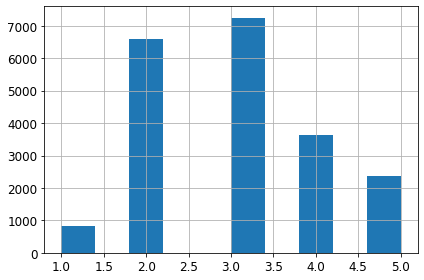

In [25]:
# Plot a histogram for the newly created categorical income feature
housing["income_cat"].hist()
save_fig(fig_id='income_strata')

## Stratified Sampling based on Income Category
Now that we have encoded the continuous `median_income` values into one of 5 categories, we can do stratified random sampling of the dataset based on the `median_income` to ensure each strata is proportionally represented in the training and test sets.

The reason we're doing this on the basis of the `median_income` column (and not other features) is because we've been told by domain experts that this is a very important feature in predicting housing prices. So it makes sense to ensure our sampling for the training/test sets helps minimize the effect of sampling bias on this feature's predictive power.

In [111]:
from sklearn.model_selection import StratifiedShuffleSplit

In [112]:
# Only 1 split (train/test) with 80% in train and 20% in test with random gen seeded at 42
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [113]:
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To test if this worked, we can find the %age of all samples in the dataset that belong to each income category, and compare them with the original income_cat histogram.

In [114]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Can also plot these as histograms and visually inspect the distribution for similarity with the original training set.

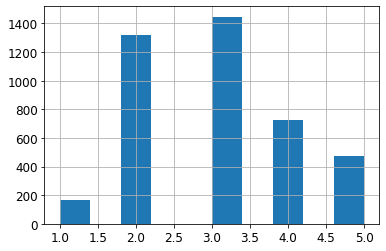

In [21]:
strat_test_set['income_cat'].hist()

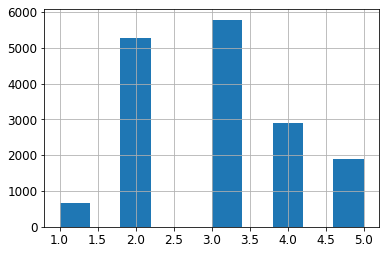

In [22]:
strat_train_set['income_cat'].hist()

Can compare the error in the proportions of each category between the full dataset and the test set using a function that makes a new dataframe. Can also use this to confirm that simply using a `train_test_split` will create a larger statified sampling error.

In [115]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

# Uses our own implementation of unstratified train/test split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Create a new dataframe with columns that show proportions of each income category in three diff sets
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing), 
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

# Create columns that show errors in random and stratified set proportions relative to original dataset
compare_props['Rand %age Error'] =  100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Stratified %age Error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

In [116]:
compare_props

,Overall,Stratified,Random,Rand %age Error,Stratified %age Error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Removing the `income_cat` column from the dataset. We don't need it anymore as we're now done with the stratified sampling.

In [117]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Data Visualization
- Never done on the test set.
- If training set is too large, is done on a subset of the training set called the exploration set.
- This isn't the case for our dataset, so we can use the training set for data visualization.

In [118]:
# Make a separate copy of the training set for visualization
housing = strat_train_set.copy()

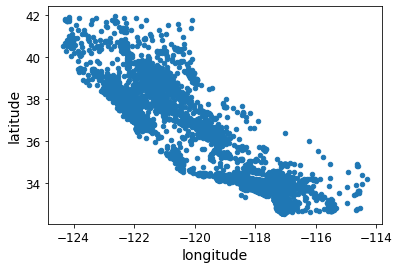

In [36]:
# Have lat and long, so good idea to create scatterplot of all districts
housing.plot(kind='scatter', x='longitude', y='latitude')

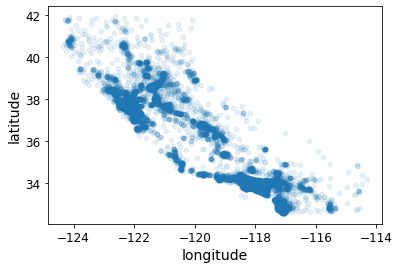

In [37]:
# Setting transparency to 0.1 to better visualize density of points in an area
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Improving the visualization by generating a colormap where high prices are red and lower prices are blue (encoded by the argumet `c`). Also, larger populations will be represented by circles of larger radii (encoded by the `s` argument).

Saving figure  housing_prices_scatterplot


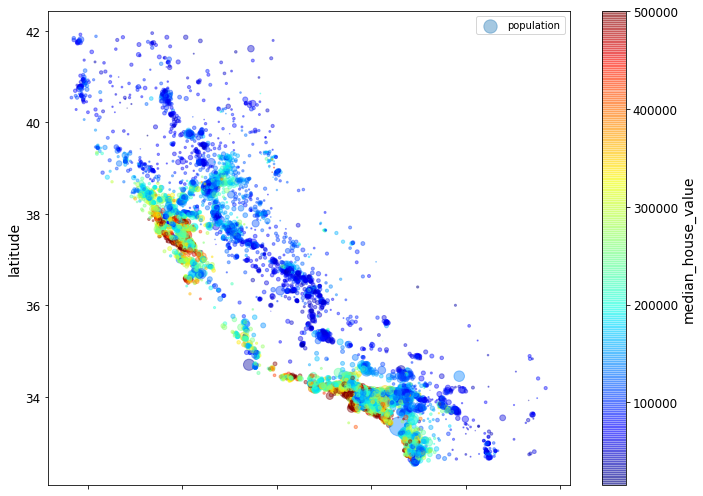

In [38]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
            s=housing['population']/100, label='population', figsize=(10, 7), 
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
save_fig('housing_prices_scatterplot')

## Correlations

In [39]:
# When dataset isn't too large, easy to compute correlations between every distinct pair of features
# Standard correlation coeff aka Pearson's r

In [119]:
corr_matrix = housing.corr()

In [120]:
# How much does each attribute correlate with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

- There is a moderate positive correlation between `median_income` and `median_house_value`. This means as the median income in an area goes up, the price of houses also goes up.
- There is a weak negative correlation between `latitude` and `median_house_value`, which supports assessment from the visualization that prices tend to go down as you go North in California.
- Correlation does not have anything to do with the slope of a relationship: only that it is linear. If there is a lot of "spread" around a straight line, then the correlationship is lower.
- Slope only determines whether a correlation is positive or negative.
- Non-linear relationships are not captured by correlation.

In [42]:
# Can also use `scatter_matrix` command in `pandas` to plot every numerical attribute against every other 
# This is also what seaborn's pairplot does

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12673b2e8>,
      dtype=object)

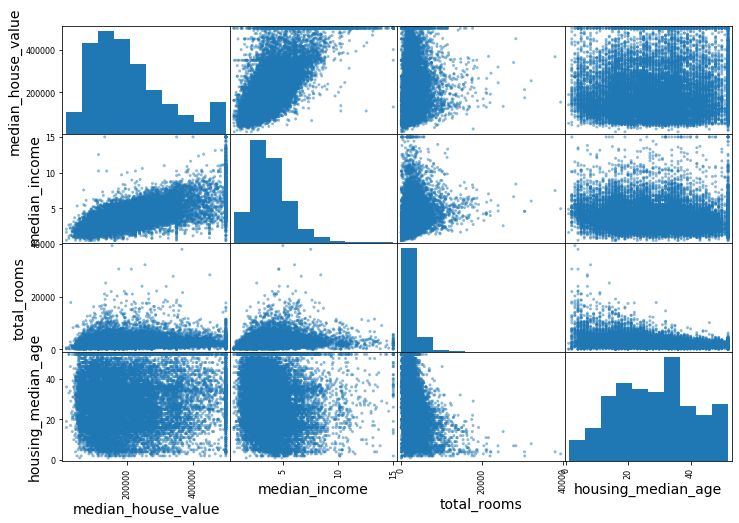

In [43]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

Median income has the highest correlation with median house value, so it is worth examining this relationship further.

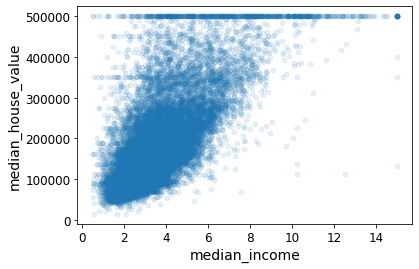

In [44]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

Strong correlation between median income and median house value, as there is not a lot of spread in the line. Also, the price cap at 500k is clearly visible, as are previously unnoticed pseudocaps at 350k and 450k.

## Exploring Feature Combinations

In [121]:
# Creating new features that are combinations of existing features
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [122]:
# Now look at the correlation matrix again: are compound features more strongly correlated with target?
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Analysis
- Bedrooms/room ratio has a stronger negative correlation than any other feature, implying that houses with fewer bedrooms in all their rooms tend to have higher prices. 
- Also, the number of rooms per household is more strongly correlated with price than is just the total rooms in the district. 
- Population per household does not seem to be very strongly correlated at all. So clearly, this approach does not warrant further exploration.
- We could keep iterating and find other combinations of features that lead to stronger correlations with the target. 

## Preprocessing for ML

In [123]:
# Create a copy of the stratified training features and targets
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [124]:
# Using sklearn's `SimpleImputer` to fill in missing values for numeric features with their median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [125]:
# Median can only be computed for numeric columns so drop proximity to ocean
housing_num = housing.drop("ocean_proximity", axis=1)

In [126]:
# The imputer object will save the median of each feature in its `statistics_` column
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [127]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [128]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [129]:
# Now transform the training set by replacing missing values for features with medians
X = imputer.transform(housing_num)

In [130]:
# Convert from numpy array to pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [131]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Dealing with `ocean_proximity`
A categorical attribute that must be converted to a numeric form before it can be used with the model.

In [132]:
housing_cat = housing[['ocean_proximity']]

In [32]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [133]:
from sklearn.preprocessing import OrdinalEncoder

In [134]:
# Instantiate OrdinalEncoder: encodes distinct values for non-numeric categorical value as ordinal numbers
ordinal_encoder = OrdinalEncoder()

In [135]:
# Transform the ocean_proximity values from strings to integers
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [136]:
# Now the ocean_proximity values will have been changed
housing_cat_encoded[:5]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.]])

In [137]:
# What value of `ocean_proximity` does each encoded integer represent?
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### What's wrong with this approach?
- Using an ordinal encoder means we'll be encoding each of the possible values of a categorical feature as a sequence of ordered integers: 0, 1, 2, 3, 4,...
- This is fine when there is an actual relationship in the data e.g. if the values of an attribute were 'bad, average, good, very good', then clearly encoding them as 0, 1, 2, 3 is okay.
- But when encoding with ordinal numbers gives a relative ordering to the possible values of the categorical variable, it can lead to the model learning incorrect associations.
- In this case, 0 encodes `<1H_OCEAN` while 4 encodes `NEAR_OCEAN`: even though the quantities these numbers represent are very similar, the "difference" between these numbers is not.

### Solution: One-hot Encoding
- Create a binary attribute (1 or 0 encoding hot or cold) for each of the possible values of the categorical variable.
- In this way, the magnitude of one value of the the encoded categorical data is the same as others, so there is no relative ordering amongst them.

In [138]:
from sklearn.preprocessing import OneHotEncoder

In [139]:
# Will obviously have to instantiate it 
cat_encoder = OneHotEncoder()

In [140]:
# Then create a new attribute for each possible value of the categorical attribute
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [141]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [142]:
print(type(housing_cat_1hot))

<class 'scipy.sparse.csr.csr_matrix'>


### What does a `sparse matrix` mean?
- The `housing_cat_1hot` matrix has multiple columns has 16,512 entries, each of which now have 5 columns: 1 per possible value of the 1-hot encoded variable.
- In each row, only one of the 5 columns will be 1. The others will be 0. This is why the matrix is sparse.
- In memory, the location or index of only the non-zero element is stored.

In [71]:
# Can convert sparse matrices to (Dense) numpy arrays
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [72]:
# Can still get list of categories with categories_ on the encoder object
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Defining a custom transformer class

A transformer class is one that we will use to implement our own custom transformations of the data. This includes
- cleaning the data in a specific way.
- replacing missing values in a specific, user-defined way.
- creating new features from existing features. 

To do this, we can inherit from `sklearn`'s `BaseEstimator` and `TransformerMixin` classes to use pre-built versions of functions for getting and setting parameters as well as the `fit_transform()` method: a convenience method that both prepares an estimator to be optimized using specific data and then actually optimises it as well.

In [143]:
from sklearn.base import BaseEstimator, TransformerMixin

In [144]:
# Indices for specific columns in the dataset
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [145]:
# Adding TransformerMixin as a base class to inherit fit_transform()
# Adding BaseEstimator as a base class to inherit get_params() and set_params() for hyperparam tuning
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """A class that adds combined attributes to the training set for California Housing"""
    # Constructor
    def __init__(self, add_bedrooms_per_room=True): # No *args or **kargs
        # Do we want to add the bedrooms_per_room attribute? Remember on instantiation
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    # Inheriting this method from BaseEstimator superclass, so nothing to do 
    def fit(self, X, y=None):
        return self # Nothing else to do. Why not call super.fit()?
    
    # Use indices of columns to create new attributes. Also create bedrooms_per_room only if
    # the obj has been instantiated with instructions to do so.
    # In the end, return the original features and newly created features
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, 
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [146]:
# Instantiate our Transformer class
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # In this case, don't want this attribute

# Use it's transform() method to get original and new features as np matrices
housing_extra_attribs = attr_adder.transform(housing.values)

In this case, the `bedrooms_per_room` feature is optional: this makes it a hyperparameter. If we wanted to test whether inclusion of a `bedrooms_per_room` would improve the model's performance. We can add all hyperparameters that we want to test to the `Transformer` class. This allows us to automate the creation of different models.

## Feature Scaling
- The process of scaling or transforming all **features** (not targets) in a dataset so that they occupy roughly the same range of values.
- This is important because most ML algorithms will not work well if their features occupy drastically different ranges e.g. neural networks expect their values to be in the same range.
- Two ways of achieving this
    - **Min Max Scaling - aka normalization** scales down all values so that they occupy the range of $[0, 1]$. This is done by subtracting the minimum value from each value and then dividing the result by the difference between the maximum and minimum values. Implemented in `sklearn` with `MnMaxScaler`.
    - **Standard Scaling - aka standardization** scales down all values by subtracting their mean (so that all features have a mean of 0) and then dividing by the standard deviation so that they have unit variance. Features may **not** necessarily be bound to a specific range, which can be a problem for some algos. Implemented with `StandardScaler`.
- Standardization is much less affected by outliers. 
- Never do feature scaling on the entire data set. Use only the training data.

## Pipelines
A series of data transformation operations that must be applied to a dataset in sequence before the data can be loaded into ML models.

In [147]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Creating a `Pipeline` object that
1. Replaces missing values for an attribute with its median value.
2. Uses the custom transformer class `CombinedAttributesAdder` to add `rooms_per_household` and `population_per_household` columns to the dataset.
3. Uses the `StandardScaler` class to standardize the features.

In [148]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Must have fit_transform
    ('attribs_adder', CombinedAttributesAdder()),  # Must have fit_transform
    ('std_scaler', StandardScaler()),              # Need not have fit_transform, only fit
])

In [149]:
# Use the pipeline to transform the data
housing_num_tr = num_pipeline.fit_transform(housing_num)

## Column Transformer
Allows us to work on the categorical and numeric columns simultaneously

In [150]:
from sklearn.compose import ColumnTransformer

In [151]:
# List of all numerical attributes
num_attribs = list(housing_num)
print(num_attribs)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [152]:
# List of all categorical attributes
cat_attribs = ['ocean_proximity']
print(cat_attribs)

['ocean_proximity']


In [153]:
# Full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), 
    ('cat', OneHotEncoder(), cat_attribs)
])

The `full_pipeline` constructor takes a list of tuples, with each tuple of the form (`name_of_transformation`, `pipeline_object`, and `data_for_pipeline`).

This pipeline is basically saing "use the rules defined in the `num_pipeline` to transform the data in the columns whose names are in the `num_attribs` list. Then combine this data with the result of passing `cat_attribs` columsn to a `OneHotEncoder()`.

## Selecting and Training Models

### Linear Regression - First Attempt

In [154]:
# Make sure you apply data pipeline first
housing_prepared = full_pipeline.fit_transform(housing)

In [155]:
# Training a linear regression model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [156]:
# Testing on some instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [157]:
# The same data must be passed through the pipeline before being fed into the model for predictions
some_data_prepared = full_pipeline.transform(some_data)

In [158]:
print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [159]:
# What are the actual prices?
print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [160]:
# Quantifying error with RMSE
from sklearn.metrics import mean_squared_error

# Store the predictions as a list
housing_predictions = lin_reg.predict(housing_prepared)

# Calculate MSE between predictions and actual prices
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [161]:
# RMSE is just the square root of MSE
lin_rmse = np.sqrt(lin_mse)

In [162]:
print("MSE: ", lin_mse)
print("RMSE: ", lin_rmse)

MSE:  4709829587.971121
RMSE:  68628.19819848923


This is clearly room for improvement. The price of houses ranges from 120k to 265k, so an RMSE of ~69k is not good. The model is **undefitting** the data. 

### Decision Tree Classifier
A highly powerful model that is capable of finding complex, nonlinear relationships in data. If this does better than the linear regression model, we'll have confirmed that the underfitting is indeed due to the features of the linear regression model being insufficient to properly learn associations between inputs and labels.

In [163]:
from sklearn.tree import DecisionTreeRegressor

In [164]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [165]:
# Evaluating on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

There is absolutely no error between the predicted and actual labels on the training data. This is a **major red flag**: the model has clearly **overfit** the training data i.e. it has memorized 1-1 mappings between individual examples and their labels in the training set. These memorized rules will not generalize well to unseen data, which means we need to find a balance between underfitting and overfitting.

### Cross Validating Decision Tree Model

In [166]:
from sklearn.model_selection import cross_val_score

In [167]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring='neg_mean_squared_error', cv=10)

In [168]:
# Negative mean squared errors converted to positive values before sqrt
tree_rmse_scores = np.sqrt(-scores)

We have to conver the `neg_mean_squared_error` to `mean_squared_error` because `sklearn` uses utility functions rather than cost functions i.e. higher values are better. 

In [169]:
# function to display cross validation results
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [170]:
display_scores(tree_rmse_scores)

Scores:  [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean:  70666.74616904806
Standard Deviation:  2928.322738055112


The decision tree actually performs worse than the original linear regression model: it's mean RMSE is 70.6k which is greater than that of the linear regression model.

### Cross Validating Linear Regression Model

In [171]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)

In [172]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [173]:
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.674001798344


The linear regression model's mean RMSE has not changed substantially even after cross validation, implying that the RMSE we calculated earlier wasn't just due to the specific subset of data used for training but actually indicative of the model's true performance.

It also confirms that even after accounting for sampling noise, the linear regression model performs better than the decision tree, which shows that just because a model is more non-linear than others does not necessarily mean it will perform better on certain regression tasks.

### Random Forest Regressor
An **ensemble regressor** that trains multiple decision trees on random subsets of the features to average out their predictions.

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [174]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [175]:
# Evaluating on the training set
housing_predictions = forest_reg.predict(housing_prepared)
forest_reg_mse = mean_squared_error(housing_labels, housing_predictions)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

18603.515021376355

In [176]:
# Cross validating
forest_reg_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                        scoring='neg_mean_squared_error', cv=10)

In [177]:
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)

In [178]:
display_scores(forest_reg_rmse_scores)

Scores:  [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean:  50182.303100336096
Standard Deviation:  2097.0810550985693


The Random Forest regressor is outperforming both the cross-validated Linear Regressor as well as the individual cross-validated decision tree. 

### Saving all models

In [179]:
from sklearn.externals import joblib

In [180]:
joblib.dump(forest_reg, 'forest_reg.pkl')

['forest_reg.pkl']

In [181]:
joblib.dump(lin_reg, 'lin_reg.pkl')

['lin_reg.pkl']

In [182]:
joblib.dump(tree_reg, 'tree_reg.pkl')

['tree_reg.pkl']

## Fine Tuning the Model

### Grid Search
Using `GridSearchCV`, `sklearn` automates the process of hyperparameter tuning. We simply provide the `GridSearchCV` object with a dictionary defining the names of the hyperparameters as well as the values we want to test for each of them. `GridSearchCV` will then train a cross-validated model for **each unique combination** of hyperparameters and find the one that gives the best performance.

This saves us from the tedious task of manually changing hyperparams.

In [183]:
from sklearn.model_selection import GridSearchCV

In [184]:
# A list of hyperparams to test is conventionally called a param_grid
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # First grid 
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]} # Second grid
]

In [195]:
# Instantiate a Random Forest Regressor to optimize hyperparams for
forest_reg = RandomForestRegressor(random_state=42)

In [196]:
# Instantiate a GridSearchCV object that will optimise the defined hyperparams for this model
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', 
                          return_train_score=True)

In [198]:
# Optimize hyperparams with a call to `fit` - this will take some time!
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The `GridSearchCV` object we have instantiated tells `sklearn` to
- first evaluate 12 combinations formed by 3 values of `n_estimators` and all 4 values of `max_features` with `bootstrap` set to its default value of `True`.
- Then evaluate 6 combinations formed by 2 values of `n_estimators` and 3 values of `max_features`, but with `bootstrap` set to `False`.
- In total, it trains 18 different combinations of hyperparams. Since it also cross validates each combination across 5 different folds, this means we're training $18 \times 5 = 90$ different `forest_reg` models.
- This will obviously take longer to train, but the result is that we will get the best parameters for this specific problem (from the subset of hyperparams that we have specified).

In [199]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [200]:
# Can also get the best estimator as an object directly
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [202]:
# Cross Validation evaluation scores for all models are also available
cvres = grid_search.cv_results_
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.067485,0.012288,0.003558,0.000339,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.193784,0.006385,0.009042,0.000962,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.671224,0.053011,0.028567,0.003488,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.108885,0.023770,0.003519,0.000423,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.317100,0.009922,0.009182,0.001225,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07


In [203]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### Randomized Search

Instead of specifying a finite number of values to search for each hyperparameter, we can instead ask `sklearn` to test a specific **number of random values** for each hyperparameter. This is **Randomized Grid Search**. 
- It allows us to look for ideal hyperparam values in a much larger search space.
- It explores `n` different hyperparam values for each hyperparam if we've asked the object to run for `n` iterations.
- It gives us greater control over allocation of computing budget by letting us specify the number of iterations.

### Analyzing the Best Models and Their Errors

In [204]:
# RandomForestRegressor can indicate the relative importance of each attribute for making predictions
feature_importances = grid_search.best_estimator_.feature_importances_

In [205]:
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [206]:
# Displaying the feature_importances_ next to their actual feature names
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

In [208]:
cat_encoder = full_pipeline.named_transformers_['cat']

In [209]:
cat_one_hot_attribs = list(cat_encoder.categories_[0])

In [210]:
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [211]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

### Test Set Evaluation

In [213]:
# Get the model with tuned hyperparams 
final_model = grid_search.best_estimator_

In [214]:
# Extracting test set features and labels
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [215]:
# Pass the test data through the data transformation pipeline
X_test_prepared = full_pipeline.transform(X_test)

In [216]:
# Use the model to make predictions on the test data
final_predictions = final_model.predict(X_test_prepared)

In [217]:
# Quantify errors
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [218]:
final_rmse

47730.22690385927

In [220]:
# 95% confidence interval: 95% of the predictions will lie in the following range
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc=squared_errors.mean(), 
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

In [221]:
# Save the final model
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']